In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-lavel/labels.csv
/kaggle/input/deeppose/images/Image_5576.jpg
/kaggle/input/deeppose/images/Image_8010.jpg
/kaggle/input/deeppose/images/Image_5775.jpg
/kaggle/input/deeppose/images/Image_7411.jpg
/kaggle/input/deeppose/images/Image_4172.jpg
/kaggle/input/deeppose/images/Image_8156.jpg
/kaggle/input/deeppose/images/Image_9381.jpg
/kaggle/input/deeppose/images/Image_4432.jpg
/kaggle/input/deeppose/images/Image_7816.jpg
/kaggle/input/deeppose/images/Image_5336.jpg
/kaggle/input/deeppose/images/Image_9275.jpg
/kaggle/input/deeppose/images/Image_1576.jpg
/kaggle/input/deeppose/images/Image_6496.jpg
/kaggle/input/deeppose/images/Image_879.jpg
/kaggle/input/deeppose/images/Image_7153.jpg
/kaggle/input/deeppose/images/Image_2538.jpg
/kaggle/input/deeppose/images/Image_8097.jpg
/kaggle/input/deeppose/images/Image_10430.jpg
/kaggle/input/deeppose/images/Image_608.jpg
/kaggle/input/deeppose/images/Image_943.jpg
/kaggle/input/deeppose/images/Image_7478.jpg
/kaggle/input/deeppo

In [2]:
pip install mediapipe 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires flatbuffers~=1.12.0, but you have flatbuffers 22.11.23 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 whic

In [3]:
import mediapipe as mp
import cv2
import time
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from collections import Counter
mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils # For drawing keypoints
points = mpPose.PoseLandmark # Landmarks


# Take Data Path

In [4]:
path = "/kaggle/input/deeppose/images" # enter dataset path
lavel_df=pd.read_csv("/kaggle/input/image-lavel/labels.csv")

# Find the Index of points value 

In [5]:
data = []
#data.append('Full Image Name')
for p in points:
        x = str(p)[13:]
        data.append(x + "_x")
        data.append(x + "_y")
        data.append(x + "_z")
        data.append(x + "_vis")
data = pd.DataFrame(columns = data) # Empty dataset
data.columns

Index(['NOSE_x', 'NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x',
       'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis',
       'LEFT_EYE_x', 'LEFT_EYE_y',
       ...
       'RIGHT_HEEL_z', 'RIGHT_HEEL_vis', 'LEFT_FOOT_INDEX_x',
       'LEFT_FOOT_INDEX_y', 'LEFT_FOOT_INDEX_z', 'LEFT_FOOT_INDEX_vis',
       'RIGHT_FOOT_INDEX_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_FOOT_INDEX_z',
       'RIGHT_FOOT_INDEX_vis'],
      dtype='object', length=132)

# Take lavel name from CSV file


In [6]:
Name_dict=tuple()
lavel_dict=tuple()
#lavel_dict[lavel_df['Mode']]=lavel_df['Image Name']
lavel_dict = tuple(lavel_df['Mode'].tolist())
Name_dict = tuple(lavel_df['Image Name'].tolist())
Image_desc= tuple(lavel_df['Full Image Name'].tolist())
Final_dict=dict()
count=0
#print(label_dict[0])
#print(Name_dict[1268])

for key,value in enumerate(lavel_dict):
    Final_dict[Name_dict[count]]=value
    count+=1
#for key,value in Final_dict.items():
 #   print(key,value)
    #print("Hello World")    


# Make Data Frame


In [7]:
df1 = pd.DataFrame(Name_dict, columns=['Image Name'])
df2 = pd.DataFrame(lavel_dict, columns=['Mode'])
df3 = pd.DataFrame(Image_desc, columns=['Full Image Name'])
Name_df = pd.concat([df1,df2,df3], axis=1)
Name_df.head()

,Image Name,Mode,Full Image Name
0,Image_1.jpg,sitting,sitting_Image_1.jpg
1,Image_4.jpg,sleeping,sleeping_Image_4.jpg
2,Image_6.jpg,sleeping,sleeping_Image_6.jpg
3,Image_15.jpg,sleeping,sleeping_Image_15.jpg
4,Image_33.jpg,sitting,sitting_Image_33.jpg


# Find data points to each image

In [8]:
count = 0

for img in os.listdir(path):
        
        temp = []
        path_temp=path+"/"+img
        img = cv2.imread(path_temp)
        
        imageWidth, imageHeight = img.shape[:2]

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        blackie = np.zeros(img.shape) # Blank image

        results = pose.process(imgRGB)

        if results.pose_landmarks:

                mpDraw.draw_landmarks(blackie, results.pose_landmarks, mpPose.POSE_CONNECTIONS) # draw landmarks on blackie

                landmarks = results.pose_landmarks.landmark
                #temp.append(list(temp.append(Image_desc[count])))
                for i,j in zip(points,landmarks):
                        
                        temp =  temp+ [j.x, j.y, j.z, j.visibility]
                        
            
                
                data.loc[count] = temp

                count +=1
        
        image = cv2.imread(path_temp)
# save the data as a csv file     
data.to_csv("unbalanced_keypoints.csv",index=False) # using index=False, to remove unwanted columns

In [9]:
unvalanced_df=pd.read_csv('/kaggle/working/unbalanced_keypoints.csv')


In [10]:
unvalanced_df

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,0.999673,0.609958,0.320569,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,0.999166,0.442420,0.524089,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,0.999246,0.302134,0.397820,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,0.996222,0.592749,0.285884,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,0.965094,0.588344,0.624122,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0.504390,0.595866,-0.504664,0.869812,0.531929,0.607813,-0.531027,0.878711,0.533023,0.617462,...,0.435232,0.336943,0.761555,0.788592,0.438532,0.281189,0.757611,0.758766,0.455507,0.277685
1077,0.497064,0.537464,-0.625106,0.882028,0.485968,0.465520,-0.677172,0.890586,0.491162,0.455910,...,0.655584,0.305084,0.740838,0.505183,0.580925,0.261889,0.764344,0.531109,0.649083,0.252748
1078,0.436602,0.600091,0.027091,0.891148,0.412828,0.583366,0.050795,0.900182,0.412518,0.578917,...,-0.324448,0.351201,0.535998,0.554742,0.001680,0.269102,0.091715,0.739137,-0.339687,0.275254
1079,0.482678,0.541393,-0.002845,0.901964,0.461430,0.527157,0.001896,0.910039,0.462554,0.514245,...,-0.058686,0.360954,1.208798,0.550127,-0.005792,0.268655,1.224058,0.745194,-0.133415,0.270133


# Using outer join to retain all images points value

In [11]:
result=pd.concat([Name_df,unvalanced_df],join='outer',axis=1) 
#result = pd.concat([Name_df,unvalanced_df],join='inner', axis=1)
#result.shape

In [12]:
print(unvalanced_df.shape)
print(result.shape)

(1081, 132)
(1269, 135)


In [13]:
result

,Image Name,Mode,Full Image Name,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,Image_1.jpg,sitting,sitting_Image_1.jpg,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,Image_4.jpg,sleeping,sleeping_Image_4.jpg,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,Image_6.jpg,sleeping,sleeping_Image_6.jpg,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,Image_15.jpg,sleeping,sleeping_Image_15.jpg,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,Image_33.jpg,sitting,sitting_Image_33.jpg,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,Image_12527.jpg,running,running_Image_12527.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1265,Image_12577.jpg,sleeping,sleeping_Image_12577.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1266,Image_12594.jpg,sleeping,sleeping_Image_12594.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1267,Image_12596.jpg,sitting,sitting_Image_12596.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
drop_Nan=result.copy()
drop_Nan.drop('Image Name', inplace=True, axis=1)
drop_Nan.drop('Mode',inplace=True,axis=1)
drop_Nan.drop('Full Image Name',inplace=True,axis=1)
#drop_Nan.drop('Unnamed: 0',inplace=True,axis=1)

# Replace missing value by Mean ,using iterative way

In [15]:

def impute_missing_values(df):
    for column in df:
        for idx, value in df[column].iteritems():
            
            if math.isnan(value):
                df.loc[idx,column] = df[column].mean(skipna=True)
            else: 
                pass
    return df

ans_df=impute_missing_values(drop_Nan)

# Combine the Image lavel with corresponding image points

In [16]:
result_task1=pd.concat([Name_df,ans_df],axis=1)
result_task1.to_csv('final_Unvalanced_keypoints.csv',index=False)


In [17]:
check=pd.read_csv('/kaggle/working/final_Unvalanced_keypoints.csv')
#check.drop('Unnamed: 0',inplace=True,axis=1)

In [18]:
check

,Image Name,Mode,Full Image Name,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,Image_1.jpg,sitting,sitting_Image_1.jpg,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,Image_4.jpg,sleeping,sleeping_Image_4.jpg,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,Image_6.jpg,sleeping,sleeping_Image_6.jpg,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,Image_15.jpg,sleeping,sleeping_Image_15.jpg,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,Image_33.jpg,sitting,sitting_Image_33.jpg,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,Image_12527.jpg,running,running_Image_12527.jpg,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
1265,Image_12577.jpg,sleeping,sleeping_Image_12577.jpg,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
1266,Image_12594.jpg,sleeping,sleeping_Image_12594.jpg,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
1267,Image_12596.jpg,sitting,sitting_Image_12596.jpg,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639


# End of Task 01

# Start of Task 02

In [19]:
smote_df=result_task1.copy()
smote_df.head()

,Image Name,Mode,Full Image Name,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,Image_1.jpg,sitting,sitting_Image_1.jpg,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,Image_4.jpg,sleeping,sleeping_Image_4.jpg,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,Image_6.jpg,sleeping,sleeping_Image_6.jpg,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,Image_15.jpg,sleeping,sleeping_Image_15.jpg,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,Image_33.jpg,sitting,sitting_Image_33.jpg,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486


# Remove less Important column for applying SMOTE

In [20]:
smote_df.drop('Image Name', inplace=True, axis=1)
smote_df.drop('Full Image Name', inplace=True, axis=1)
#smote_df.drop('Unnamed: 0', inplace=True, axis=1)

In [21]:
smote_df.head()

,Mode,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,sitting,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,0.999673,0.609958,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,sleeping,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,0.999166,0.442420,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,sleeping,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,0.999246,0.302134,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,sleeping,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,0.996222,0.592749,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,sitting,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,0.965094,0.588344,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486


# Preprocessing using lavel encoding

In [22]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
smote_df['Mode']= label_encoder.fit_transform(smote_df['Mode'])
  
#smote_df['Mode'].unique()
smote_df.head()


,Mode,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,1,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,0.999673,0.609958,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,2,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,0.999166,0.442420,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,2,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,0.999246,0.302134,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,2,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,0.996222,0.592749,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,1,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,0.965094,0.588344,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486


# Divide the entire dataset into predictor and target portion 

In [23]:
y=smote_df['Mode']
X=smote_df.drop('Mode', inplace=False, axis=1)


# Split the dataset in train , test portion

In [24]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8, stratify = y, random_state=100)


In [25]:
y_train.value_counts()/len(y_train)

2    0.551724
1    0.298522
0    0.149754
Name: Mode, dtype: float64

# Handling class imbalance using SMOTE based techniques

In [26]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({2: 560, 1: 303, 0: 152})
After Counter({2: 560, 1: 560, 0: 560})


In [27]:
# Get the list of all column names from headers
column_headers = data.columns.values.tolist()
print("The Column Header :", column_headers)

The Column Header : ['NOSE_x', 'NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z', 'LEFT_EYE_vis', 'LEFT_EYE_OUTER_x', 'LEFT_EYE_OUTER_y', 'LEFT_EYE_OUTER_z', 'LEFT_EYE_OUTER_vis', 'RIGHT_EYE_INNER_x', 'RIGHT_EYE_INNER_y', 'RIGHT_EYE_INNER_z', 'RIGHT_EYE_INNER_vis', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_z', 'RIGHT_EYE_vis', 'RIGHT_EYE_OUTER_x', 'RIGHT_EYE_OUTER_y', 'RIGHT_EYE_OUTER_z', 'RIGHT_EYE_OUTER_vis', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_z', 'LEFT_EAR_vis', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_z', 'RIGHT_EAR_vis', 'MOUTH_LEFT_x', 'MOUTH_LEFT_y', 'MOUTH_LEFT_z', 'MOUTH_LEFT_vis', 'MOUTH_RIGHT_x', 'MOUTH_RIGHT_y', 'MOUTH_RIGHT_z', 'MOUTH_RIGHT_vis', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z', 'LEFT_SHOULDER_vis', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z', 'RIGHT_SHOULDER_vis', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_z', 'LEFT_ELBOW_vis',

# Make  the updated dataset after SMOTE Technique 

In [28]:

data_res = pd.DataFrame(X_train_sm)
data_res['y_train_sm'] = y_train_sm
data_res = np.concatenate((X_train_sm, np.vstack(y_train_sm)), axis = 1)
#data_res = pd.DataFrame(data_res,columns=['NOSE_x','NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis', 'LEFT_EYE_x', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z', 'LEFT_EYE_vis', 'LEFT_EYE_OUTER_x', 'LEFT_EYE_OUTER_y', 'LEFT_EYE_OUTER_z', 'LEFT_EYE_OUTER_vis', 'RIGHT_EYE_INNER_x', 'RIGHT_EYE_INNER_y', 'RIGHT_EYE_INNER_z', 'RIGHT_EYE_INNER_vis', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_z', 'RIGHT_EYE_vis', 'RIGHT_EYE_OUTER_x', 'RIGHT_EYE_OUTER_y', 'RIGHT_EYE_OUTER_z', 'RIGHT_EYE_OUTER_vis', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_z', 'LEFT_EAR_vis', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_z', 'RIGHT_EAR_vis', 'MOUTH_LEFT_x', 'MOUTH_LEFT_y', 'MOUTH_LEFT_z', 'MOUTH_LEFT_vis', 'MOUTH_RIGHT_x', 'MOUTH_RIGHT_y', 'MOUTH_RIGHT_z', 'MOUTH_RIGHT_vis', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z', 'LEFT_SHOULDER_vis', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z', 'RIGHT_SHOULDER_vis', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_z', 'LEFT_ELBOW_vis', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_z', 'RIGHT_ELBOW_vis', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_z', 'LEFT_WRIST_vis', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_z', 'RIGHT_WRIST_vis', 'LEFT_PINKY_x', 'LEFT_PINKY_y', 'LEFT_PINKY_z', 'LEFT_PINKY_vis', 'RIGHT_PINKY_x', 'RIGHT_PINKY_y', 'RIGHT_PINKY_z', 'RIGHT_PINKY_vis', 'LEFT_INDEX_x', 'LEFT_INDEX_y', 'LEFT_INDEX_z', 'LEFT_INDEX_vis', 'RIGHT_INDEX_x', 'RIGHT_INDEX_y', 'RIGHT_INDEX_z', 'RIGHT_INDEX_vis', 'LEFT_THUMB_x', 'LEFT_THUMB_y', 'LEFT_THUMB_z', 'LEFT_THUMB_vis', 'RIGHT_THUMB_x', 'RIGHT_THUMB_y', 'RIGHT_THUMB_z', 'RIGHT_THUMB_vis', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_z', 'LEFT_HIP_vis', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_z', 'RIGHT_HIP_vis', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_z', 'LEFT_KNEE_vis', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_z', 'RIGHT_KNEE_vis', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_z', 'LEFT_ANKLE_vis', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_z', 'RIGHT_ANKLE_vis', 'LEFT_HEEL_x', 'LEFT_HEEL_y', 'LEFT_HEEL_z', 'LEFT_HEEL_vis', 'RIGHT_HEEL_x', 'RIGHT_HEEL_y', 'RIGHT_HEEL_z', 'RIGHT_HEEL_vis', 'LEFT_FOOT_INDEX_x', 'LEFT_FOOT_INDEX_y', 'LEFT_FOOT_INDEX_z', 'LEFT_FOOT_INDEX_vis', 'RIGHT_FOOT_INDEX_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_FOOT_INDEX_z', 'RIGHT_FOOT_INDEX_vis'])
data_res=pd.DataFrame(data_res,columns= ['NOSE_x', 'NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z', 'LEFT_EYE_vis', 'LEFT_EYE_OUTER_x', 'LEFT_EYE_OUTER_y', 'LEFT_EYE_OUTER_z', 'LEFT_EYE_OUTER_vis', 'RIGHT_EYE_INNER_x', 'RIGHT_EYE_INNER_y', 'RIGHT_EYE_INNER_z', 'RIGHT_EYE_INNER_vis', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_z', 'RIGHT_EYE_vis', 'RIGHT_EYE_OUTER_x', 'RIGHT_EYE_OUTER_y', 'RIGHT_EYE_OUTER_z', 'RIGHT_EYE_OUTER_vis', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_z', 'LEFT_EAR_vis', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_z', 'RIGHT_EAR_vis', 'MOUTH_LEFT_x', 'MOUTH_LEFT_y', 'MOUTH_LEFT_z', 'MOUTH_LEFT_vis', 'MOUTH_RIGHT_x', 'MOUTH_RIGHT_y', 'MOUTH_RIGHT_z', 'MOUTH_RIGHT_vis', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z', 'LEFT_SHOULDER_vis', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z', 'RIGHT_SHOULDER_vis', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_z', 'LEFT_ELBOW_vis', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_z', 'RIGHT_ELBOW_vis', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_z', 'LEFT_WRIST_vis', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_z', 'RIGHT_WRIST_vis', 'LEFT_PINKY_x', 'LEFT_PINKY_y', 'LEFT_PINKY_z', 'LEFT_PINKY_vis', 'RIGHT_PINKY_x', 'RIGHT_PINKY_y', 'RIGHT_PINKY_z', 'RIGHT_PINKY_vis', 'LEFT_INDEX_x', 'LEFT_INDEX_y', 'LEFT_INDEX_z', 'LEFT_INDEX_vis', 'RIGHT_INDEX_x', 'RIGHT_INDEX_y', 'RIGHT_INDEX_z', 'RIGHT_INDEX_vis', 'LEFT_THUMB_x', 'LEFT_THUMB_y', 'LEFT_THUMB_z', 'LEFT_THUMB_vis', 'RIGHT_THUMB_x', 'RIGHT_THUMB_y', 'RIGHT_THUMB_z', 'RIGHT_THUMB_vis', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_z', 'LEFT_HIP_vis', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_z', 'RIGHT_HIP_vis', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_z', 'LEFT_KNEE_vis', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_z', 'RIGHT_KNEE_vis', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_z', 'LEFT_ANKLE_vis', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_z', 'RIGHT_ANKLE_vis', 'LEFT_HEEL_x', 'LEFT_HEEL_y', 'LEFT_HEEL_z', 'LEFT_HEEL_vis', 'RIGHT_HEEL_x', 'RIGHT_HEEL_y', 'RIGHT_HEEL_z', 'RIGHT_HEEL_vis', 'LEFT_FOOT_INDEX_x', 'LEFT_FOOT_INDEX_y', 'LEFT_FOOT_INDEX_z', 'LEFT_FOOT_INDEX_vis', 'RIGHT_FOOT_INDEX_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_FOOT_INDEX_z', 'RIGHT_FOOT_INDEX_vis','Mode_Int','Mode'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [29]:
data_res.head()

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,Mode_Int,Mode
0,0.455502,0.611547,-0.104295,0.976904,0.476834,0.607108,-0.122714,0.977988,0.479423,0.611612,...,-0.070821,0.657565,0.378816,0.275535,-0.088404,0.885861,0.397065,0.332558,2.0,2.0
1,0.200754,0.353231,-0.162207,0.799231,0.180068,0.326735,-0.169410,0.803573,0.180067,0.311123,...,1.058321,0.377346,-0.076322,0.245147,1.038633,0.461957,0.189670,0.174194,2.0,2.0
2,0.579287,0.393148,-0.217340,0.934867,0.546393,0.358469,-0.194492,0.951479,0.550449,0.348960,...,2.030975,0.896372,-0.117949,0.213224,1.999826,1.013052,-0.451763,0.207518,1.0,1.0
3,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,0.527070,0.390980,...,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639,2.0,2.0
4,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,-0.972911,0.600447,...,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875,0.0,0.0


In [30]:
# converting 'Mode' from float to int
data_res['Mode'] = data_res['Mode'].astype(int)
# converting 'Mode_Int' from float to int
data_res['Mode_Int'] = data_res['Mode_Int'].astype(int)

# convert Numerical to categorical value 

In [31]:
# replacing values
data_res['Mode'].replace([0,1,2],
                        ['sitting','sleeping','running'], inplace=True)

In [32]:
data_res.head()

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,Mode_Int,Mode
0,0.455502,0.611547,-0.104295,0.976904,0.476834,0.607108,-0.122714,0.977988,0.479423,0.611612,...,-0.070821,0.657565,0.378816,0.275535,-0.088404,0.885861,0.397065,0.332558,2,running
1,0.200754,0.353231,-0.162207,0.799231,0.180068,0.326735,-0.169410,0.803573,0.180067,0.311123,...,1.058321,0.377346,-0.076322,0.245147,1.038633,0.461957,0.189670,0.174194,2,running
2,0.579287,0.393148,-0.217340,0.934867,0.546393,0.358469,-0.194492,0.951479,0.550449,0.348960,...,2.030975,0.896372,-0.117949,0.213224,1.999826,1.013052,-0.451763,0.207518,1,sleeping
3,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,0.527070,0.390980,...,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639,2,running
4,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,-0.972911,0.600447,...,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875,0,sitting


In [33]:
# shift column 'Mode' to first position
first_column = data_res.pop('Mode')
# first_column) function
data_res.insert(0, 'Mode', first_column)

In [34]:
second_column=data_res.pop('Mode_Int')
data_res.insert(1, 'Mode_Int', second_column)

In [35]:
data_res.head()

,Mode,Mode_Int,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,running,2,0.455502,0.611547,-0.104295,0.976904,0.476834,0.607108,-0.122714,0.977988,...,0.375813,0.386950,-0.070821,0.657565,0.378816,0.275535,-0.088404,0.885861,0.397065,0.332558
1,running,2,0.200754,0.353231,-0.162207,0.799231,0.180068,0.326735,-0.169410,0.803573,...,0.172482,0.162269,1.058321,0.377346,-0.076322,0.245147,1.038633,0.461957,0.189670,0.174194
2,sleeping,1,0.579287,0.393148,-0.217340,0.934867,0.546393,0.358469,-0.194492,0.951479,...,-0.145985,0.257108,2.030975,0.896372,-0.117949,0.213224,1.999826,1.013052,-0.451763,0.207518
3,running,2,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
4,sitting,0,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,...,1.758528,0.139738,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875


In [36]:
data_res.to_csv('Over_Sampling_balanced_keypoints.csv',index=False)

In [37]:
balanced_df=pd.read_csv('/kaggle/working/Over_Sampling_balanced_keypoints.csv')

# Check the result of Balanced CSV File

In [38]:
result_task2=balanced_df
result_task2.head()

,Mode,Mode_Int,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,running,2,0.455502,0.611547,-0.104295,0.976904,0.476834,0.607108,-0.122714,0.977988,...,0.375813,0.386950,-0.070821,0.657565,0.378816,0.275535,-0.088404,0.885861,0.397065,0.332558
1,running,2,0.200754,0.353231,-0.162207,0.799231,0.180068,0.326735,-0.169410,0.803573,...,0.172482,0.162269,1.058321,0.377346,-0.076322,0.245147,1.038633,0.461957,0.189670,0.174194
2,sleeping,1,0.579287,0.393148,-0.217340,0.934867,0.546393,0.358469,-0.194492,0.951479,...,-0.145985,0.257108,2.030975,0.896372,-0.117949,0.213224,1.999826,1.013052,-0.451763,0.207518
3,running,2,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
4,sitting,0,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,...,1.758528,0.139738,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875


# Check the result of Unvalanced CSV File

In [39]:
result_task1.head()

,Image Name,Mode,Full Image Name,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,Image_1.jpg,sitting,sitting_Image_1.jpg,0.606632,0.329200,0.061796,0.999606,0.609481,0.320142,0.042655,...,0.023590,0.959782,0.622528,0.828734,-0.076116,0.991843,0.736940,0.837133,0.003538,0.965406
1,Image_4.jpg,sleeping,sleeping_Image_4.jpg,0.456803,0.577851,-0.346534,0.999089,0.438520,0.538617,-0.309713,...,0.355754,0.867399,1.317254,0.818543,0.294677,0.893795,1.308338,0.980777,0.147636,0.871048
2,Image_6.jpg,sleeping,sleeping_Image_6.jpg,0.311459,0.429813,-0.090511,0.999176,0.300632,0.407118,-0.107763,...,0.613204,0.848720,0.723802,1.062345,-0.648338,0.902534,0.670442,0.410634,0.666975,0.847805
3,Image_15.jpg,sleeping,sleeping_Image_15.jpg,0.592151,0.295921,-0.485669,0.996195,0.592951,0.286191,-0.495253,...,0.094832,0.859449,0.689533,0.936532,-0.178750,0.904984,0.502226,0.763211,0.052410,0.854858
4,Image_33.jpg,sitting,sitting_Image_33.jpg,0.598226,0.645254,0.055409,0.952024,0.587694,0.631247,0.051681,...,-0.210551,0.826808,0.786962,0.718550,-0.080754,0.839789,0.843808,0.569665,-0.228343,0.810486


In [40]:
print("shape of dataFrame, before Uppersampling",result_task1.shape)
print("shape of dataFrame, after Uppersampling",result_task2.shape)

shape of dataFrame, before Uppersampling (1269, 135)
shape of dataFrame, after Uppersampling (1680, 134)


# End of Task 02 Over sampling portion



# Start  of Task 02 Under sampling portion 


In [41]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X, y, train_size=0.8, stratify = y, random_state=100)


In [42]:
counter = Counter(y_train)
print('Before',counter)
# undersampling the train dataset using RandomUnderSampler
under = RandomUnderSampler(random_state=0)

X_train_RS, y_train_RS = under.fit_resample(X_train, y_train)

counter = Counter(y_train_RS)
print('After',counter)

Before Counter({2: 560, 1: 303, 0: 152})
After Counter({0: 152, 1: 152, 2: 152})


In [43]:

data_res = pd.DataFrame(X_train_RS)
data_res['y_train_RS'] = y_train_RS
data_res = np.concatenate((X_train_RS, np.vstack(y_train_RS)), axis = 1)
#data_res = pd.DataFrame(data_res,columns=['NOSE_x','NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis', 'LEFT_EYE_x', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z', 'LEFT_EYE_vis', 'LEFT_EYE_OUTER_x', 'LEFT_EYE_OUTER_y', 'LEFT_EYE_OUTER_z', 'LEFT_EYE_OUTER_vis', 'RIGHT_EYE_INNER_x', 'RIGHT_EYE_INNER_y', 'RIGHT_EYE_INNER_z', 'RIGHT_EYE_INNER_vis', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_z', 'RIGHT_EYE_vis', 'RIGHT_EYE_OUTER_x', 'RIGHT_EYE_OUTER_y', 'RIGHT_EYE_OUTER_z', 'RIGHT_EYE_OUTER_vis', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_z', 'LEFT_EAR_vis', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_z', 'RIGHT_EAR_vis', 'MOUTH_LEFT_x', 'MOUTH_LEFT_y', 'MOUTH_LEFT_z', 'MOUTH_LEFT_vis', 'MOUTH_RIGHT_x', 'MOUTH_RIGHT_y', 'MOUTH_RIGHT_z', 'MOUTH_RIGHT_vis', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z', 'LEFT_SHOULDER_vis', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z', 'RIGHT_SHOULDER_vis', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_z', 'LEFT_ELBOW_vis', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_z', 'RIGHT_ELBOW_vis', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_z', 'LEFT_WRIST_vis', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_z', 'RIGHT_WRIST_vis', 'LEFT_PINKY_x', 'LEFT_PINKY_y', 'LEFT_PINKY_z', 'LEFT_PINKY_vis', 'RIGHT_PINKY_x', 'RIGHT_PINKY_y', 'RIGHT_PINKY_z', 'RIGHT_PINKY_vis', 'LEFT_INDEX_x', 'LEFT_INDEX_y', 'LEFT_INDEX_z', 'LEFT_INDEX_vis', 'RIGHT_INDEX_x', 'RIGHT_INDEX_y', 'RIGHT_INDEX_z', 'RIGHT_INDEX_vis', 'LEFT_THUMB_x', 'LEFT_THUMB_y', 'LEFT_THUMB_z', 'LEFT_THUMB_vis', 'RIGHT_THUMB_x', 'RIGHT_THUMB_y', 'RIGHT_THUMB_z', 'RIGHT_THUMB_vis', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_z', 'LEFT_HIP_vis', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_z', 'RIGHT_HIP_vis', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_z', 'LEFT_KNEE_vis', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_z', 'RIGHT_KNEE_vis', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_z', 'LEFT_ANKLE_vis', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_z', 'RIGHT_ANKLE_vis', 'LEFT_HEEL_x', 'LEFT_HEEL_y', 'LEFT_HEEL_z', 'LEFT_HEEL_vis', 'RIGHT_HEEL_x', 'RIGHT_HEEL_y', 'RIGHT_HEEL_z', 'RIGHT_HEEL_vis', 'LEFT_FOOT_INDEX_x', 'LEFT_FOOT_INDEX_y', 'LEFT_FOOT_INDEX_z', 'LEFT_FOOT_INDEX_vis', 'RIGHT_FOOT_INDEX_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_FOOT_INDEX_z', 'RIGHT_FOOT_INDEX_vis'])
data_res=pd.DataFrame(data_res,columns= ['NOSE_x', 'NOSE_y', 'NOSE_z', 'NOSE_vis', 'LEFT_EYE_INNER_x', 'LEFT_EYE_INNER_y', 'LEFT_EYE_INNER_z', 'LEFT_EYE_INNER_vis', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_z', 'LEFT_EYE_vis', 'LEFT_EYE_OUTER_x', 'LEFT_EYE_OUTER_y', 'LEFT_EYE_OUTER_z', 'LEFT_EYE_OUTER_vis', 'RIGHT_EYE_INNER_x', 'RIGHT_EYE_INNER_y', 'RIGHT_EYE_INNER_z', 'RIGHT_EYE_INNER_vis', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_z', 'RIGHT_EYE_vis', 'RIGHT_EYE_OUTER_x', 'RIGHT_EYE_OUTER_y', 'RIGHT_EYE_OUTER_z', 'RIGHT_EYE_OUTER_vis', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_z', 'LEFT_EAR_vis', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_z', 'RIGHT_EAR_vis', 'MOUTH_LEFT_x', 'MOUTH_LEFT_y', 'MOUTH_LEFT_z', 'MOUTH_LEFT_vis', 'MOUTH_RIGHT_x', 'MOUTH_RIGHT_y', 'MOUTH_RIGHT_z', 'MOUTH_RIGHT_vis', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_z', 'LEFT_SHOULDER_vis', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_z', 'RIGHT_SHOULDER_vis', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_z', 'LEFT_ELBOW_vis', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_z', 'RIGHT_ELBOW_vis', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_z', 'LEFT_WRIST_vis', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_z', 'RIGHT_WRIST_vis', 'LEFT_PINKY_x', 'LEFT_PINKY_y', 'LEFT_PINKY_z', 'LEFT_PINKY_vis', 'RIGHT_PINKY_x', 'RIGHT_PINKY_y', 'RIGHT_PINKY_z', 'RIGHT_PINKY_vis', 'LEFT_INDEX_x', 'LEFT_INDEX_y', 'LEFT_INDEX_z', 'LEFT_INDEX_vis', 'RIGHT_INDEX_x', 'RIGHT_INDEX_y', 'RIGHT_INDEX_z', 'RIGHT_INDEX_vis', 'LEFT_THUMB_x', 'LEFT_THUMB_y', 'LEFT_THUMB_z', 'LEFT_THUMB_vis', 'RIGHT_THUMB_x', 'RIGHT_THUMB_y', 'RIGHT_THUMB_z', 'RIGHT_THUMB_vis', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_z', 'LEFT_HIP_vis', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_z', 'RIGHT_HIP_vis', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_z', 'LEFT_KNEE_vis', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_z', 'RIGHT_KNEE_vis', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_z', 'LEFT_ANKLE_vis', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_z', 'RIGHT_ANKLE_vis', 'LEFT_HEEL_x', 'LEFT_HEEL_y', 'LEFT_HEEL_z', 'LEFT_HEEL_vis', 'RIGHT_HEEL_x', 'RIGHT_HEEL_y', 'RIGHT_HEEL_z', 'RIGHT_HEEL_vis', 'LEFT_FOOT_INDEX_x', 'LEFT_FOOT_INDEX_y', 'LEFT_FOOT_INDEX_z', 'LEFT_FOOT_INDEX_vis', 'RIGHT_FOOT_INDEX_x', 'RIGHT_FOOT_INDEX_y', 'RIGHT_FOOT_INDEX_z', 'RIGHT_FOOT_INDEX_vis','Mode_Int','Mode'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [44]:
data_res

,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,LEFT_EYE_x,LEFT_EYE_y,...,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis,Mode_Int,Mode
0,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,-0.972911,0.600447,...,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875,0.0,0.0
1,0.561628,0.571820,-1.600892,0.848519,0.611797,0.626978,-1.582564,0.870734,0.616002,0.656912,...,0.024988,0.731052,0.552816,0.249571,-0.032305,0.614708,0.656967,0.245482,0.0,0.0
2,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,0.527070,0.390980,...,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639,0.0,0.0
3,1.105461,0.578077,-0.564449,0.874301,1.151997,0.582879,-0.591724,0.900224,1.168736,0.564057,...,-0.688425,2.311806,1.040716,0.332657,-0.850719,2.315288,1.146812,0.341014,0.0,0.0
4,0.134543,0.280936,-0.004522,0.928012,0.119964,0.258000,-0.023820,0.929189,0.123124,0.251760,...,0.746492,0.807181,-0.171284,0.357873,0.703465,0.733504,0.223813,0.344140,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,0.660658,0.586858,-0.588051,0.924331,0.674865,0.573855,-0.590829,0.928218,0.685921,0.572965,...,0.738698,0.650557,0.717815,0.288406,0.081393,0.594021,0.575798,0.266794,2.0,2.0
452,0.280524,0.658813,-0.224595,0.950273,0.291751,0.662899,-0.224840,0.956270,0.295207,0.659189,...,0.280549,0.296943,-0.210520,0.154830,0.264212,0.278894,-0.001063,0.125915,2.0,2.0
453,0.436602,0.600091,0.027091,0.891148,0.412828,0.583366,0.050795,0.900182,0.412518,0.578917,...,0.535998,0.554742,0.001680,0.269102,0.091715,0.739137,-0.339687,0.275254,2.0,2.0
454,0.497121,0.361389,-0.028140,0.872587,0.488967,0.317078,-0.017711,0.871592,0.487189,0.316403,...,1.070775,0.641927,0.712576,0.285946,1.106609,0.775186,0.228160,0.312052,2.0,2.0


In [45]:
# converting 'Mode' from float to int
data_res['Mode'] = data_res['Mode'].astype(int)
# converting 'Mode_Int' from float to int
data_res['Mode_Int'] = data_res['Mode_Int'].astype(int)

In [46]:
# replacing values
data_res['Mode'].replace([0,1,2],
                        ['sitting','sleeping','running'], inplace=True)

In [47]:
# shift column 'Mode' to first position
first_column = data_res.pop('Mode')
# first_column) function
data_res.insert(0, 'Mode', first_column)
second_column=data_res.pop('Mode_Int')
data_res.insert(1, 'Mode_Int', second_column)

In [48]:
data_res.to_csv('Under_Sampling_balanced_keypoints.csv',index=False)

In [49]:
under_sample=pd.read_csv('/kaggle/working/Under_Sampling_balanced_keypoints.csv')
under_sample

,Mode,Mode_Int,NOSE_x,NOSE_y,NOSE_z,NOSE_vis,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_z,LEFT_EYE_INNER_vis,...,RIGHT_HEEL_z,RIGHT_HEEL_vis,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_z,LEFT_FOOT_INDEX_vis,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_z,RIGHT_FOOT_INDEX_vis
0,sitting,0,-1.094454,0.728600,-1.161523,0.865837,-1.008326,0.584805,-1.257074,0.861600,...,1.758528,0.139738,-0.550117,4.835573,0.592623,0.128988,-0.554822,4.795248,1.229463,0.122875
1,sitting,0,0.561628,0.571820,-1.600892,0.848519,0.611797,0.626978,-1.582564,0.870734,...,0.805101,0.267180,0.024988,0.731052,0.552816,0.249571,-0.032305,0.614708,0.656967,0.245482
2,sitting,0,0.515100,0.424032,-0.553964,0.892366,0.521377,0.393194,-0.559306,0.901318,...,0.681102,0.283468,0.618778,1.264079,0.489515,0.252180,0.571858,1.267983,0.460537,0.255639
3,sitting,0,1.105461,0.578077,-0.564449,0.874301,1.151997,0.582879,-0.591724,0.900224,...,1.390745,0.398096,-0.688425,2.311806,1.040716,0.332657,-0.850719,2.315288,1.146812,0.341014
4,sitting,0,0.134543,0.280936,-0.004522,0.928012,0.119964,0.258000,-0.023820,0.929189,...,0.211633,0.355538,0.746492,0.807181,-0.171284,0.357873,0.703465,0.733504,0.223813,0.344140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,running,2,0.660658,0.586858,-0.588051,0.924331,0.674865,0.573855,-0.590829,0.928218,...,0.634678,0.280179,0.738698,0.650557,0.717815,0.288406,0.081393,0.594021,0.575798,0.266794
452,running,2,0.280524,0.658813,-0.224595,0.950273,0.291751,0.662899,-0.224840,0.956270,...,0.214141,0.138857,0.280549,0.296943,-0.210520,0.154830,0.264212,0.278894,-0.001063,0.125915
453,running,2,0.436602,0.600091,0.027091,0.891148,0.412828,0.583366,0.050795,0.900182,...,-0.324448,0.351201,0.535998,0.554742,0.001680,0.269102,0.091715,0.739137,-0.339687,0.275254
454,running,2,0.497121,0.361389,-0.028140,0.872587,0.488967,0.317078,-0.017711,0.871592,...,0.256491,0.353067,1.070775,0.641927,0.712576,0.285946,1.106609,0.775186,0.228160,0.312052


# Final Output


In [50]:
print("shape of dataFrame, before Uppersampling",result_task1.shape)
print("shape of dataFrame, after Uppersampling",under_sample.shape)

shape of dataFrame, before Uppersampling (1269, 135)
shape of dataFrame, after Uppersampling (456, 134)


# End of Task 02

# Additional Result Visualization

In [51]:
print("shape of without sampling",result_task1.shape)
print("shape of under sampling",under_sample.shape)
print("shape of upper sampling",result_task2.shape)

shape of without sampling (1269, 135)
shape of under sampling (456, 134)
shape of upper sampling (1680, 134)


In [52]:
Unvalance_x,_=result_task1.shape
Over_x,_=result_task2.shape
under_x,_=under_sample.shape


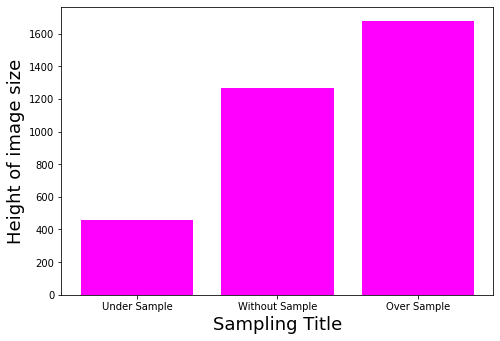

In [53]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Sample = ['Under Sample', 'Without Sample', 'Over Sample']
len_label_image = [under_x,Unvalance_x,Over_x]
plt.ylabel('Height of image size',fontsize=18)
plt.xlabel('Sampling Title',fontsize=18)
ax.bar(Sample,len_label_image,color='magenta')
plt.show()

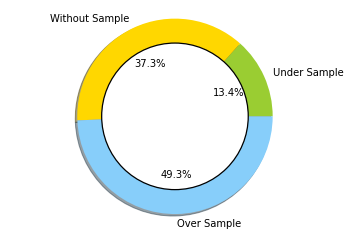

In [54]:
 
labels = 'Under Sample', 'Without Sample', 'Over Sample'
sizes = [under_x,Unvalance_x,Over_x]
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  